# Laboratorium 4

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

FIG_EPS = 0.1

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < FIG_EPS:
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

In [4]:
%matplotlib notebook

<IPython.core.display.Javascript object>


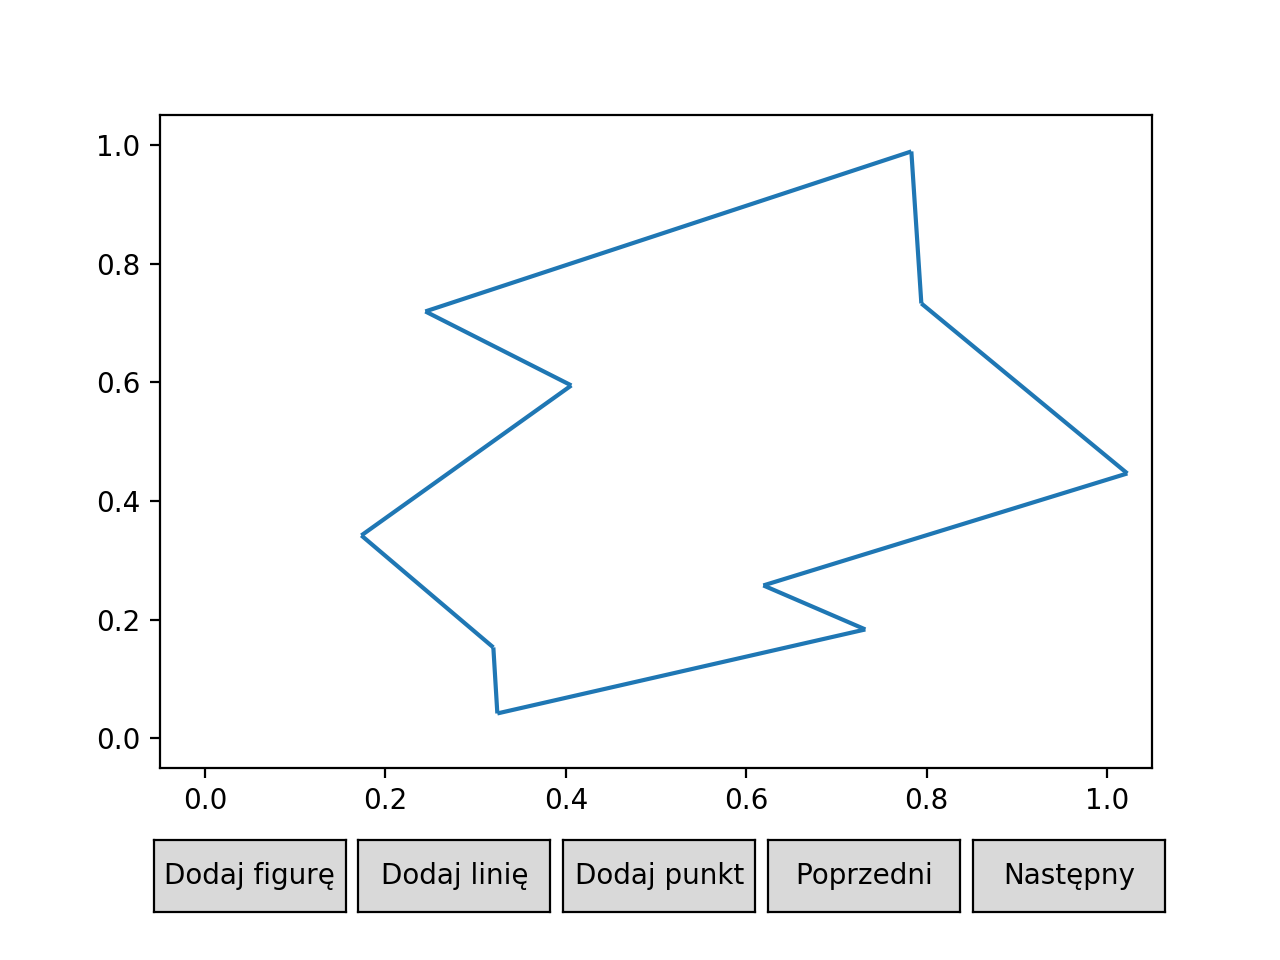

In [5]:
plotx = Plot()
plotx.draw()

In [6]:
import yaml
p = Plot([plotx.get_added_elements()])

with open('somefilex.json', 'w') as file:
    file.write(p.toJson())
    
with open('somefilex.json', 'r') as file:
    items = file.read()

items = items[1:-1]
items = yaml.load(items, Loader=yaml.FullLoader)


lines = items.get("lines")[0]

def get_points(lines):
    points = []
    for l in lines:
        points.append(tuple(l[0]))
    return points


## 2 Monotoniczność

In [11]:
def monoton(lines):
    polygon = get_points(lines)
    count = 0
    div_prev = 0
    for i in range(1, len(polygon)):
        dif = polygon[i][1] -  polygon[i-1][1]
        if div_prev * dif < 0:
            count += 1
        div_prev = dif
    return count <= 3

In [503]:
print(monoton(lines))

True


#### Orient

In [9]:
#położenie c względem a i b

eps = 1e-30

def det(a,b,c):                                            
    m = [a[0], a[1], b[0], b[1], c[0], c[1]]
    d = np.linalg.det(np.concatenate((np.reshape(m, (3, 2)), np.ones((3,1))), axis=1))
    if d > - eps and d < eps:       #współliniowe
        return 0
    return d

## 3 Klasyfikacja i kolorowanie

In [294]:
#wielokąt jako lista kolejnych wierzchołków

def name_and_color(lines):
    poly = get_points(lines)
    polygon = []
    
    #klasa do przechowywania wierzchołków
    class vert:                                
        def __init__(self, crd, vtype):
            self.crd = crd
            self.vtype = vtype
            
        def if_monoton(self):
            return self.vtype != 3 and self.vtype != 4
        
    #typy wierzchołków
    #0 - beginning, 1 - ending, 2 - correct, 3 - connecting, 4 - dividing
    
    #klasyfikacja wierzchołków
    def ptype(p,prv,nxt):          
        if (prv[1]-p[1])*(nxt[1]-p[1]) <= 0:
            return 2
        elif prv[1]-p[1] < 0 and nxt[1]-p[1] < 0 and det(prv,nxt,p) < 0:
            return 0
        elif prv[1]-p[1] > 0 and nxt[1]-p[1] > 0 and det(prv,nxt,p) < 0:
            return 1
        elif prv[1]-p[1] > 0 and nxt[1]-p[1] > 0 and det(prv,nxt,p) > 0:
            return 3  
        elif prv[1]-p[1] < 0 and nxt[1]-p[1] < 0 and det(prv,nxt,p) > 0:
            return 4
    
    edges = []
    poly.append(poly[0])
    poly.append(poly[1])
    for i in range(1, len(poly)-1):
        p = poly[i]
        prv = poly[i-1]
        nxt = poly[i+1]
        polygon.append(vert(p, ptype(p,prv,nxt)))
        edges.append([p,prv])
    
    #kolorowanie
    points = [[],[],[],[],[]]
    for p in range(len(polygon)):
        points[polygon[p].vtype].append(polygon[p].crd)
    
    scenes = [Scene([PointsCollection(points[0], color='lime'), PointsCollection(points[1], color='red'),
                    PointsCollection(points[2], color='brown'), PointsCollection(points[3], color='darkblue'),
                    PointsCollection(points[4], color='cyan')], [LinesCollection(edges)])]
    
    #sprawdzanie monotoniczności na podstawie klasyfikacji punktów
    monotonicity = False
    if len(points[3]) == 0 and len(points[4]) == 0:
        monotonicity = True
        
    return monotonicity,scenes

<IPython.core.display.Javascript object>


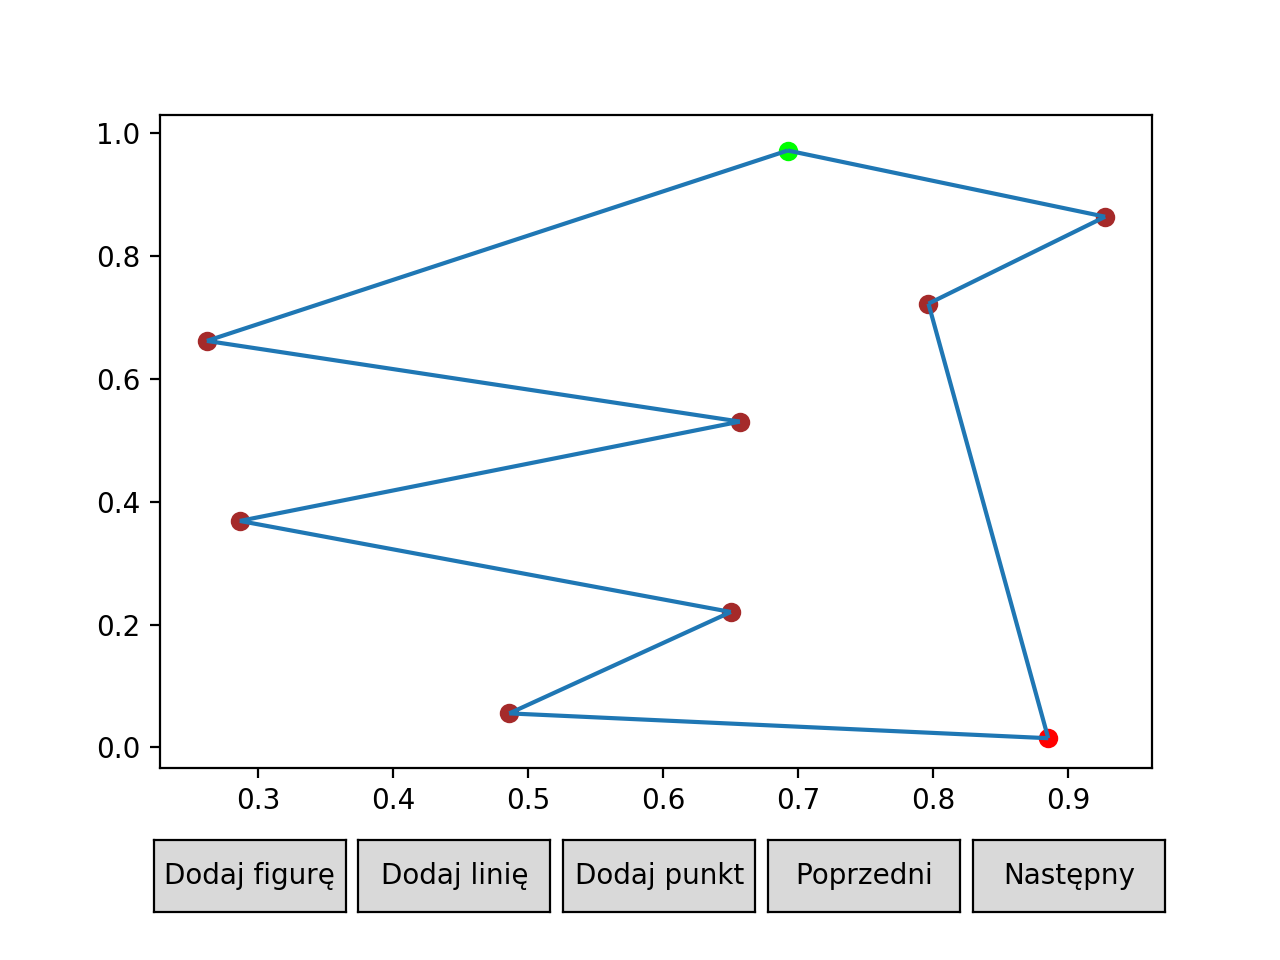

True


In [460]:
#test kolorowania
monotonicity,scenes = name_and_color(lines)

plot=Plot(scenes)
plot.draw()
print(monotonicity)

## 4 Triangulacja

In [8]:
def triangul(lines):
    
    poly = get_points(lines)
    
    if not monoton(lines):
        return []
    
    #top, vertice, reshaping list of vertices to have top at 0
    p_max_y = sorted(poly, key = lambda x: x[1], reverse = True)[0]
    y_max_index = poly.index(p_max_y)
    poly = poly[y_max_index:] + poly[:y_max_index]
    #y_max_index = 0
    
    #structure of points: position and chain
    class v:
        def __init__(self,crd, left):
            self.pos = crd
            self.left = left
            
    polygon = [v(poly[0],True)]
    
    #chain splitting
    for p in range(1, len(poly)):
        if poly[p][1] < poly[p-1][1]:
            polygon.append(v(poly[p], True))
        else:
            polygon.append(v(poly[p], False))
    
    #sorting list of vertices
    polygon = sorted(polygon, key = lambda p: p.pos[1], reverse = True)
    top = polygon[0]
    diagonals = []
    scenes = [Scene([PointsCollection(poly, color = "black")], [LinesCollection(lines)])]
    
    #initiating stack
    S = []
    S.append(top)
    S.append(polygon[1])
    
    #printing stack
    def to_print(S):
        p = [s.pos for s in S]
        return p
    
    triangles = []
    
    for j in range(2, len(polygon)):
         
        p = polygon[j]
        if p.left != S[-1].left:
            
            #cutting triangles off
            while len(S) > 0:
                u = S.pop()
                if u.left == p.left or u == top :
                    continue
                scenes += [Scene([PointsCollection(poly, color = "black"), PointsCollection([p.pos], color = "pink"), PointsCollection(to_print(S)+[u.pos], color = "lime")], [LinesCollection(lines), LinesCollection([[p.pos, u.pos], [p.pos, S[-1].pos], [S[-1].pos, u.pos]], color = "crimson")])]
                diagonals.append([p.pos, u.pos])
                triangles.append([p.pos, u.pos, S[-1].pos])
                
            S.append(polygon[j-1])
            S.append(polygon[j])
        else:
            
            #left/right chain
            if p.left == True:
                e = -1
            else:
                e = 1
                
            flag = True
            while len(S) > 1 and flag:
                u = S[-1]
                u_p = S[-2]
                
                #cutting triangle off
                if det(p.pos, u_p.pos, u.pos)*e < 0:      
                    scenes += [Scene([PointsCollection(poly, color = "black"), PointsCollection([p.pos], color = "pink"),PointsCollection(to_print(S), color = "lime")], [LinesCollection(lines), LinesCollection([[p.pos, u_p.pos], [p.pos, u.pos], [u.pos, u_p.pos]], color = "red")])]
                    diagonals.append([p.pos, u_p.pos])
                    u_del = S.pop()
                    triangles.append([p.pos, u.pos, u_p.pos])
                else:
                    to_stack = [u_p,u,p]
                    S.extend(to_stack)
                    flag = False
            if flag:
                S.append(p)
                
    scenes += [Scene([PointsCollection([])], [LinesCollection(diagonals, color = "orange"), LinesCollection(lines)])]
    return scenes, triangles
    

<IPython.core.display.Javascript object>


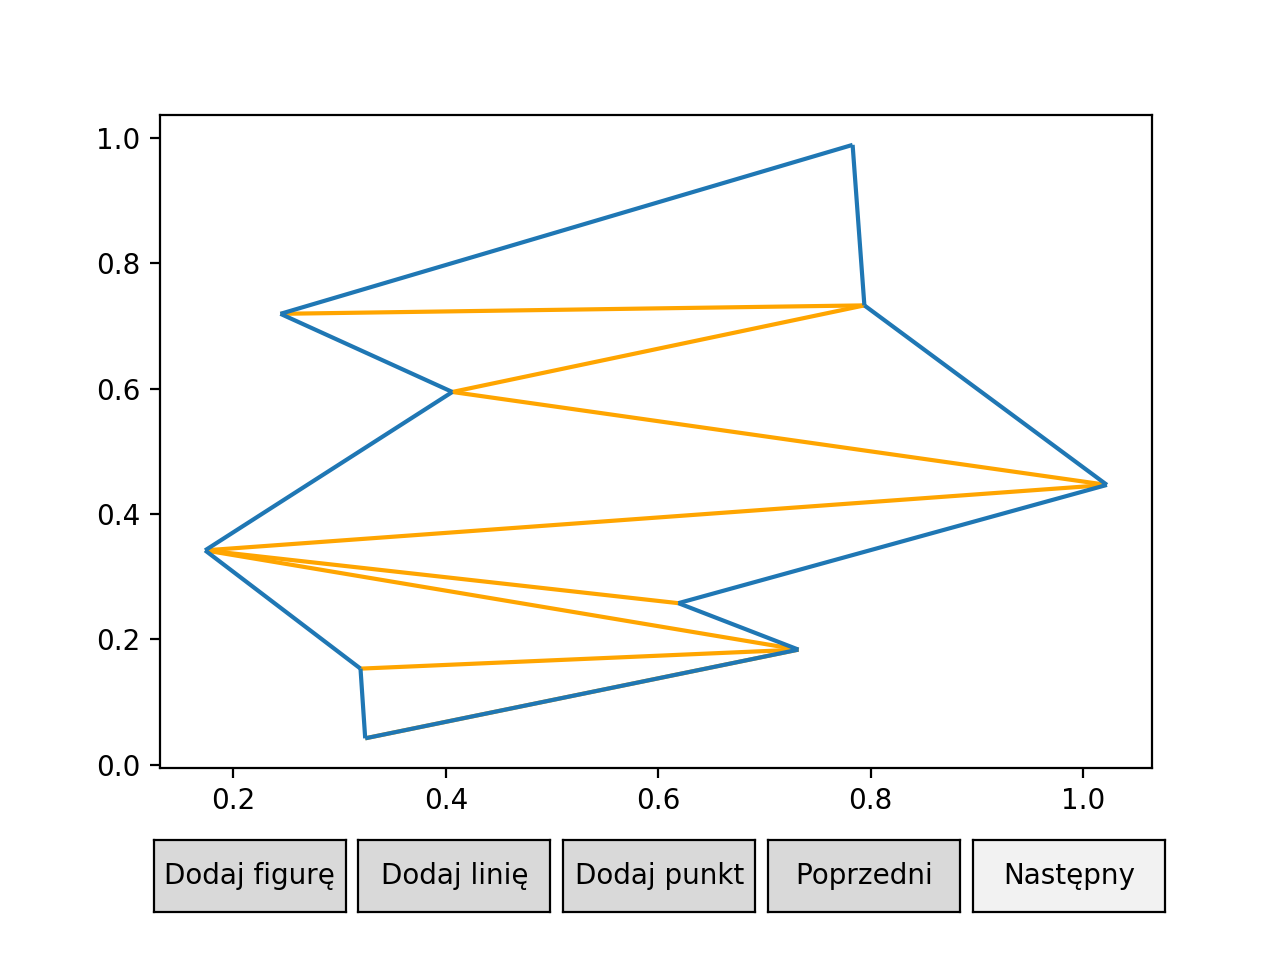

In [12]:
scenes, T = triangul(lines)

plot=Plot(scenes)
plot.draw()